In [1]:
import pandas as pd 
import numpy as np 
import tensorflow as tf 
import keras 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Activation, Dropout, Flatten, BatchNormalization
from keras.preprocessing import image
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt 

In [2]:
label_map = ['Anger', 'Fear', 'Happy', 'Sad', ]
df = pd.read_csv('prodata1.csv')
im = df['pixels']
df.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,1,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,3,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,1,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
5,3,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
6,2,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
7,2,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
8,1,255 254 255 254 254 179 122 107 95 124 149 150...,Training
9,0,30 24 21 23 25 25 49 67 84 103 120 125 130 139...,Training


In [3]:
def getData(filename):
    #imagesize = 48x48
    Y = []
    X = []
    first = True
    for line in open(filename):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])
    X, Y = np.array(X) / 255.0, np.array(Y)
    return X,Y

In [4]:
X, Y = getData('prodata1.csv')
num_class = len(set(Y))
print('No. of classes are ',num_class)

No. of classes are  4


In [5]:
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

In [7]:

# from keras.layers import Dense, Dropout, Flatten
# from keras.layers import Conv2D,Activation,MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from tensorflow.keras.utils import normalize
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import Input
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint


optimizer = Adam(learning_rate=0.0001, epsilon=1e-08, decay=0.0)


learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000001)

# input_shape=data.shape[1:] #50,50,1
input_shape= (48,48,1)
inp=Input(shape=input_shape)
convs=[]

parrallel_kernels=[3,5,7,9]

for k in range(len(parrallel_kernels)):

    conv = Conv2D(128, parrallel_kernels[k],padding='same',activation='relu',input_shape=input_shape,strides=1)(inp)
    convs.append(conv)

out = Concatenate()(convs)
conv_model = Model(inp,out)

model = Sequential()
model.add(conv_model)

model.add(Conv2D(256,(3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4,input_dim=64,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 48, 48, 512)       21504     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 46, 46, 256)       1179904   
_________________________________________________________________
activation (Activation)      (None, 46, 46, 256)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 256)       1024      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 21, 64)        147520    
_________________________________________________________________
activation_1 (Activation)    (None, 21, 21, 64)        0

In [8]:
path_model='grouped_conv.h5' 
vgg_model_history = model.fit(x=X_train,     
            y=y_train, 
            batch_size=64, 
            epochs=50, 
            validation_data=(X_test,y_test),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )

Epoch 1/50
354/354 [==============================] - 48s 115ms/step - loss: 2.1161 - accuracy: 0.2685 - val_loss: 1.4052 - val_accuracy: 0.2502
Epoch 2/50
354/354 [==============================] - 37s 104ms/step - loss: 1.9327 - accuracy: 0.2800 - val_loss: 1.3693 - val_accuracy: 0.3441
Epoch 3/50
354/354 [==============================] - 39s 109ms/step - loss: 1.7973 - accuracy: 0.2871 - val_loss: 1.3842 - val_accuracy: 0.3107
Epoch 4/50
354/354 [==============================] - 39s 109ms/step - loss: 1.6935 - accuracy: 0.2956 - val_loss: 1.3383 - val_accuracy: 0.3719
Epoch 5/50
354/354 [==============================] - 38s 106ms/step - loss: 1.6112 - accuracy: 0.3103 - val_loss: 1.3427 - val_accuracy: 0.3660
Epoch 6/50
354/354 [==============================] - 34s 97ms/step - loss: 1.5611 - accuracy: 0.3144 - val_loss: 1.3212 - val_accuracy: 0.3854
Epoch 7/50
354/354 [==============================] - 34s 95ms/step - loss: 1.5145 - accuracy: 0.3225 - val_loss: 1.3212 - val_accu

In [9]:
def plot_graph(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' +metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

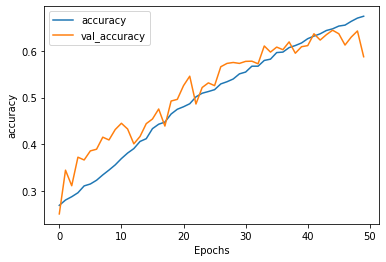

In [10]:
%matplotlib inline
plot_graph(vgg_model_history,'accuracy')

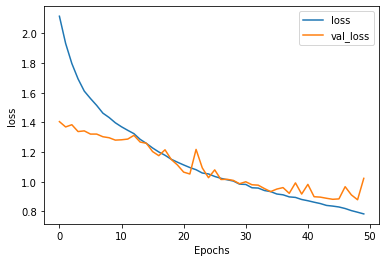

In [11]:
plot_graph(vgg_model_history,'loss')